## Imports

In [ ]:
import numpy as np
from math import log
import matplotlib.pyplot as plt
import cv2
import os
import time
import random

## Folder operations

In [ ]:
!rm -rf sample_data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/UWr\ -\ Machine\ Learning/ffhq-dataset

/content/drive/.shortcut-targets-by-id/1u2xu7bSrWxrbUxk-dT-UvEJq8IjdmNTP/ffhq-dataset


In [ ]:
%cd thumbnails128x128/

/content/drive/.shortcut-targets-by-id/1u2xu7bSrWxrbUxk-dT-UvEJq8IjdmNTP/ffhq-dataset/thumbnails128x128


In [ ]:
!mkdir /content/ffhq

In [ ]:
!cp 00000/* /content/ffhq/
!cp 01000/* /content/ffhq/
!cp 02000/* /content/ffhq/
!cp 03000/* /content/ffhq/
!cp 04000/* /content/ffhq/
!cp 05000/* /content/ffhq/

In [ ]:
import json

In [ ]:
# !git clone https://github.com/opencv/opencv.git

In [ ]:
ffhq_info = json.load(open('/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/ffhq-dataset-v2.json'))

In [ ]:
info_file = ""

for key in ffhq_info.keys():
    if any(i in ffhq_info[key]['in_the_wild']['file_path'] for i in ['01000', '02000', '03000', '04000']):
        info_file = info_file +"/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/" +ffhq_info[key]['in_the_wild']['file_path'] +"  1  " +" ".join([str(i) for i in ffhq_info[key]['in_the_wild']['face_rect']]) +"\n"

info_file

'/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01000.png  1  1468 642 2210 1384\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01001.png  1  2364 932 3224 1792\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01002.png  1  604 740 1222 1360\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01003.png  1  792 792 2032 2032\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01004.png  1  328 1016 948 1636\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01005.png  1  970 572 1860 1464\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01006.png  1  1716 642 2458 1384\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset/in-the-wild-images/01000/01007.png  1  1384 1138 2128 1880\n/content/drive/MyDrive/UWr - Machine Learning/ffhq-dataset

## Main code

In [ ]:
window_size = 24
n_pos = 500
n_neg = 1000

### Get data

In [ ]:
def get_samples(path, n_samples, window_size):
    samples = []
    filenames = os.listdir(path)
    

    for _ in range(n_samples):
        file = random.choice(filenames)
        if file.endswith(".png") or file.endswith(".jpg"):
            filenames.remove(file)
            samples.append(
                cv2.resize(
                    cv2.imread(path + file, cv2.IMREAD_GRAYSCALE),
                    (window_size, window_size),
                    interpolation=cv2.INTER_NEAREST
                ).astype('float64')
            )

    return samples

def subwindow_integral(subwindow):
    integral = np.zeros(subwindow.shape)

    for r in range(subwindow.shape[0]):
        for c in range(subwindow.shape[1]):
            greyIntegralVal = subwindow[r,c]

            if (r-1 >= 0 and c-1 >= 0):
                greyIntegralVal -= integral[r-1, c-1]

            if (r-1 >= 0):
                greyIntegralVal += integral[r-1, c]

            if (c-1 >= 0):
                greyIntegralVal += integral[r, c-1]

            integral[r,c]  = greyIntegralVal

    return integral


# Generate positive samples
positive_samples = get_samples("/content/ffhq/", n_pos, window_size)
# positive_samples_rotated = [np.rot90(np.rot90(np.rot90(el))) for el in positive_samples]
positive_samples = positive_samples + positive_samples_rotated

# Generate Negative samples
negative_samples = get_samples("/content/drive/MyDrive/UWr - Machine Learning/natural_images/", n_neg, window_size)
# negative_samples_rotated = [np.rot90(np.rot90(np.rot90(el))) for el in negative_samples]
negative_samples = negative_samples + negative_samples_rotated

# Shuffle all the samples
np.random.shuffle(positive_samples)
np.random.shuffle(negative_samples)

print("Positive samples: ", len(positive_samples))
print("Negative samples: ", len(negative_samples))

split = 0.95
pos_split = int(len(positive_samples) * split)
neg_split = int(len(negative_samples) * split)

training_set = positive_samples[0:pos_split] + negative_samples[0:neg_split]
testing_set = positive_samples[pos_split:] + negative_samples[neg_split:]

training_integrals = [subwindow_integral(el) for el in training_set]
testing_integrals = [subwindow_integral(el) for el in testing_set]

nrPos = pos_split
nrNeg = neg_split

nrPos_test = len(positive_samples) - nrPos
nrNeg_test = len(negative_samples) - nrNeg

training_labels = [1] * nrPos + [-1] * nrNeg
testing_labels = [1] * nrPos_test + [-1] * nrNeg_test

print("For training")
print("Positives: "+str(nrPos))
print("Negatives: "+str(nrNeg))

print("For testing")
print("Positives: "+str(nrPos_test))
print("Negatives: "+str(nrNeg_test))

Positive samples:  1000
Negative samples:  2000
For training
Positives: 950
Negatives: 1900
For testing
Positives: 50
Negatives: 100


In [ ]:
class Haar(object):
    def __init__(self, type, feature, size, shape, start):
        self.type=type
        self.feature = cv2.resize(feature, (shape[1] * size, shape[0] * size), interpolation=cv2.INTER_NEAREST)
        self.start = start
        self.size=size
        self.shape = shape

class WeakClassifier(object):
    def __init__(self, haar, theta, sign, weight):
        self.haar = haar
        self.theta = theta
        self.sign = sign
        self.weight = weight

def blockSum(integral, w, h, w_kernel_size, h_kernel_size):
    endw = int(w + w_kernel_size - 1)
    endh = int(h + h_kernel_size - 1)
    w = int(w)
    h = int(h)
    sum = integral[endh, endw]
    if (w > 0):
        sum -= integral[endh, w - 1]
    if (h > 0):
        sum -= integral[h - 1, endw]
    if (h > 0 and w > 0):
        sum += integral[h - 1, w - 1]
    return sum

def get_haar_score_fast(haar, subwindow, subwindow_integral):
    r = haar.start[0]
    c = haar.start[1]
    size_w = haar.feature.shape[1]
    size_h = haar.feature.shape[0]

    if size_w == 2 and size_h == 2:
        # Simple feature, not using integral
        if haar.type == 1:
            return subwindow[r, c] + subwindow[r+1, c] - subwindow[r, c+1] - subwindow[r+1, c+1]
        elif haar.type == 2:
            return subwindow[r, c] + subwindow[r, c+1] - subwindow[r+1, c] - subwindow[r+1, c+1]
        elif haar.type == 5:
            return subwindow[r, c] + subwindow[r+1, c+1] - subwindow[r, c+1] - subwindow[r+1, c]
        elif haar.type == 6:
            return subwindow[r+1, c] + subwindow[r, c+1] - subwindow[r, c] - subwindow[r+1, c+1]
    else:
        # More complex features, using integral to reduce array references
        if haar.type == 1:
            return blockSum(subwindow_integral, c, r, size_w / 2, size_h) - blockSum(subwindow_integral, c + (size_w / 2), r, size_w / 2, size_h)
        elif haar.type == 2:
            return blockSum(subwindow_integral, c, r, size_w, size_h / 2) - blockSum(subwindow_integral, c, r + (size_h / 2), size_w, size_h / 2)
        elif haar.type == 3:
            return blockSum(subwindow_integral, c, r, size_w, size_h) - 2 * blockSum(subwindow_integral, c + (size_w / 3), r, size_w / 3, size_h)
        elif haar.type == 4:
            return blockSum(subwindow_integral, c, r, size_w, size_h) - 2 * blockSum(subwindow_integral, c, r + (size_h / 3), size_w, size_h / 3)
        elif haar.type == 5:
            return blockSum(subwindow_integral, c, r, size_w, size_h) - 2 * (blockSum(subwindow_integral, c + (size_w / 2), r ,size_w / 2, size_h / 2) + blockSum(subwindow_integral, c, r + (size_h / 2), size_w / 2, size_h / 2))
        elif haar.type == 6:
            return blockSum(subwindow_integral, c, r, size_w, size_h) - 2 * (blockSum(subwindow_integral, c, r, size_w / 2, size_h / 2) + blockSum(subwindow_integral, c + (size_w / 2), r + (size_h / 2), size_w / 2, size_h / 2))
        elif haar.type == 7:
            if (size_w == 3):
                return blockSum(subwindow_integral, c,r, size_w, size_h) - 2 * subwindow[r + 1, c + 1]
            else:
                return blockSum(subwindow_integral, c, r, size_w, size_h) - 2 * blockSum(subwindow_integral, c + (size_w / 3), r + (size_h / 3), size_w / 3, size_h / 3)


def feature_weighted_error_rate(actual, predicted, weights):
    return sum(weights * (np.not_equal(actual, predicted)))


def predict(score, classifier):
    if score < classifier.theta:
        return -classifier.sign
    return classifier.sign


def display(fovea):
    plt.imshow(fovea, interpolation='nearest')
    plt.show()


# Generate many haar features
features_start=[]

# Define haar feature types
haar1 = np.array([[1, -1],
                  [1, -1]])

haar2 = np.array([[1, 1],
                  [-1, -1]])

haar3 = np.array([[1, -1, 1],
                  [1, -1, 1]])

haar4 = np.array([[1, 1],
                  [-1, -1],
                  [1, 1]])

haar5 = np.array([[1, -1],
                  [-1, 1]])

haar6 = np.array([[-1, 1],
                  [1, -1]])

haar7 = np.array([[1, 1, 1],
                  [1, -1, 1],
                  [1, 1, 1]])


# Define many sizes for all feature types
haar_feature_types=[haar1, haar2, haar3, haar4, haar5, haar6, haar7]
for f in range(len(haar_feature_types)):
    shape = haar_feature_types[f].shape
    if 3 in haar_feature_types[f].shape:
        max_size = 4
    else:
        max_size = 7

    for s in range(1, max_size+1):
        features_start.append(Haar(f+1, haar_feature_types[f], s, shape, (0,0)))

features = []
for j in features_start:
    # Get all posible starting locations for this feature
    starting_positions = []
    space = (window_size - j.shape[0] * j.size, window_size - j.shape[1] * j.size)
    for k in range(space[0]+1):
        for l in range(space[1]+1):
            starting_positions.append((k, l))

    for loc in starting_positions:
        features.append(Haar(j.type, j.feature, j.size, j.shape, loc))


features = list(features)
n1 = len(set(features))
n2 = len(features)
print("Number of unique features : ", n1)

feature_weights=[]
weak_classifires = []


np.random.shuffle(features)

errors = []
scores = []
thetas = []
polarities = []
# For every feature, find best threshold and compute corresponding weighted error
for j in features:
    avgPosScore = 0.0
    avgNegScore = 0.0
    # Apply feature to each image and get threshold for current feature (current location)
    for i in range(len(training_set)):
        score=get_haar_score_fast(j, training_set[i], training_integrals[i])
        scores.append(score)

        if training_labels[i] == 1:
            avgPosScore += score
        else:
            avgNegScore += score

    avgPosScore = avgPosScore / nrPos
    avgNegScore = avgNegScore / nrNeg
    if avgPosScore > avgNegScore:
        polarity = 1
    else:
        polarity = -1
    polarities.append(polarity)

    # Optimal theta found
    theta = (avgPosScore + avgNegScore) / 2
    thetas.append(theta)

Number of unique features :  12670


### Cascade creation

In [ ]:
F_target = 0.001
f = 0.5

F_i = 1

cascade = []
start_time = time.time()

image_weights = [1.0 / (2 * nrPos)] * nrPos + [1.0/(2 * nrNeg)] * nrNeg

show_stuff = False
fi_history = [F_i]

while F_i > F_target and (len(fi_history) <= 5 or len(set(fi_history)) >= 3):
    ## Train classifier for stage i

    #best_feature_index = 0
    best_weak_classifier = 0
    lowest_error = float("inf")

    #image_weights = [1.0/(2*nrNeg)]*nrNeg + [1.0/(2*nrPos)]*nrPos
    total = sum(image_weights)
    image_weights = [w / total for w in image_weights]
    TP=0
    TN=0

    f_i = 1
    cycle = 0

    #while f_i > f: # change condition TP>0.5 and TN>0.5 ?!
    while (TP / nrPos < 0.5) and (TN / nrNeg < 0.5):
        total = sum(image_weights)
        if total != 1:
            image_weights = [w / total for w in image_weights]

        print(" ")
        errors = []
        # For every feature, find best threshold and compute corresponding weighted error
        loop_cnt = 0
        inner_loop_cnt = 0
        for j in features:

            # Create classifier object
            w_classif = WeakClassifier(j, thetas[loop_cnt], polarities[loop_cnt], 0)

            # Compute weighted error
            predicted = []
            for sample in range(len(training_set)):
                # Get predictions of all samples
                score=scores[inner_loop_cnt]
                predicted.append(predict(score, w_classif))
                inner_loop_cnt += 1

            weighted_error=feature_weighted_error_rate(training_labels, predicted, image_weights)
            errors.append(weighted_error)

            # Look for the lowest error and keep track of the corresponding classifier
            if weighted_error < lowest_error:
                lowest_error = weighted_error
                best_weak_classifier = w_classif

            loop_cnt += 1

        if show_stuff:
            plt.plot(errors)
            plt.show()

        ## Choose weak classifier with lowest error ##
        beta_t = lowest_error / (1 - lowest_error)

        if beta_t == 0:
            inverted_weighth = 0
        else:
            inverted_weighth = log(1 / beta_t)
        best_weak_classifier.weight = inverted_weighth

        ## Update weights and evaluate current weak classifier ##
        predicted = []
        scores_debug = []
        for sample in range(len(training_set)):
            # Get weighted classification error
            score=get_haar_score_fast(best_weak_classifier.haar, training_set[sample], training_integrals[sample])
            scores_debug.append(score)
            predicted.append(predict(score, best_weak_classifier))

        FP = 0.0
        FN = 0.0
        TP = 0.0
        TN = 0.0
        colors_predicted = []
        for k in range(len(image_weights)):
            # if sample is correctly classified

            if training_labels[k] == 1 and predicted[k] == -1:
                FN += 1
            if training_labels[k] == -1 and predicted[k] == 1:
                FP += 1

            # Update image weights
            if training_labels[k] == predicted[k]:
                image_weights[k] = image_weights[k] * beta_t
                if predicted[k] == 1:
                    TP += 1
                if predicted[k] == -1:
                    TN += 1

            if predicted[k] == -1:
                colors_predicted.append('r')
            else:
                colors_predicted.append('g')

        ## Evaluate f_i
        f_i = (FP / (2 * nrNeg)) + (FN / (2 * nrPos))
        print("f_i: " + str(f_i))

        print("TP, TN, FP, FN for the current weak classifier:")
        print(TP / nrPos, TN / nrNeg, FP / nrNeg, FN / nrPos)

        ## Visualize the performace of weak classifier for training samples
        if show_stuff:
            plt.scatter(range(nrPos + nrNeg), scores_debug, c = colors_predicted)
            plt.vlines(nrPos, min(scores_debug), max(scores_debug))
            plt.plot(range(nrPos + nrNeg), [best_weak_classifier.theta] * (nrPos + nrNeg))
            plt.xlim(0, nrPos + nrNeg)
            plt.show()

        print("Threshold of the best feature: ", best_weak_classifier.theta)

        cycle += 1

    cascade.append(best_weak_classifier)

    print(len(features))

    print(best_weak_classifier.haar.feature)

    strong_FP = 0.0
    strong_FN = 0.0

    cascade_scores = []
    cascade_colors_predicted = []
    for l in range(len(training_set)):
        strong_score = 0.0
        for w_class in cascade:
            strong_score += w_class.weight * predict(get_haar_score_fast(w_class.haar, training_set[l], training_integrals[l]), w_class)
        cascade_scores.append(strong_score)
        clas = np.sign(strong_score)
        if clas == -1:
            cascade_colors_predicted.append('r')
        else:
            cascade_colors_predicted.append('g')

        if training_labels[l] == 1 and clas == -1:
            strong_FN += 1
        if training_labels[l] == -1 and clas == 1:
            strong_FP += 1

    ## Visualize the performace of the cascade on training samples
    if show_stuff:
        plt.scatter(range(nrPos + nrNeg), cascade_scores, c = cascade_colors_predicted)
        plt.vlines(nrPos, min(cascade_scores), max(cascade_scores))
        plt.plot(range(nrPos + nrNeg), [0] * (nrPos + nrNeg))
        plt.xlim(0, nrPos + nrNeg)
        plt.show()

    F_i = (strong_FP / (2 * nrNeg)) + (strong_FN / (2 * nrPos))
    print("F_i: ", F_i)
    print("Cascade size: ", len(cascade))

    fi_history.append(F_i)
    if len(fi_history) == 6:
        fi_history.pop(0)

print("--- %s seconds ---" % (time.time() - start_time))

 
f_i: 0.2773684210526316
TP, TN, FP, FN for the current weak classifier:
0.7347368421052631 0.7105263157894737 0.2894736842105263 0.26526315789473687
Threshold of the best feature:  -146.47368421052633
12670
[[ 1  1  1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1]
 [-1 -1 -1  1  1  1]
 [-1 -1 -1  1  1  1]
 [-1 -1 -1  1  1  1]]
F_i:  0.2773684210526316
Cascade size:  1
 
f_i: 0.2813157894736842
TP, TN, FP, FN for the current weak classifier:
0.7042105263157895 0.7331578947368421 0.2668421052631579 0.29578947368421055
Threshold of the best feature:  -94.0707894736842
12670
[[ 1  1  1  1]
 [ 1  1  1  1]
 [-1 -1 -1 -1]
 [-1 -1 -1 -1]]
F_i:  0.2773684210526316
Cascade size:  2
 
f_i: 0.2997368421052632
TP, TN, FP, FN for the current weak classifier:
0.6673684210526316 0.7331578947368421 0.2668421052631579 0.33263157894736844
Threshold of the best feature:  293.3342105263158
12670
[[ 1  1  1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1]
 [ 1  1  1 -1 -1 -1]


### Testing

Cascade:
[<__main__.WeakClassifier object at 0x7f3531c9c990>, <__main__.WeakClassifier object at 0x7f35be13e410>, <__main__.WeakClassifier object at 0x7f35bdcdbc90>, <__main__.WeakClassifier object at 0x7f363df47b90>, <__main__.WeakClassifier object at 0x7f35be13ead0>, <__main__.WeakClassifier object at 0x7f35be029090>, <__main__.WeakClassifier object at 0x7f35bdf45ad0>, <__main__.WeakClassifier object at 0x7f3531b9b690>, <__main__.WeakClassifier object at 0x7f3531b9b9d0>, <__main__.WeakClassifier object at 0x7f35bdfaf8d0>, <__main__.WeakClassifier object at 0x7f3531aeec90>, <__main__.WeakClassifier object at 0x7f3531aee4d0>, <__main__.WeakClassifier object at 0x7f3531b9bc50>, <__main__.WeakClassifier object at 0x7f3531aeedd0>, <__main__.WeakClassifier object at 0x7f3531b9b950>, <__main__.WeakClassifier object at 0x7f3531b9bc90>, <__main__.WeakClassifier object at 0x7f3531b9bcd0>, <__main__.WeakClassifier object at 0x7f3531b9b590>, <__main__.WeakClassifier object at 0x7f3531b9b250>, <_

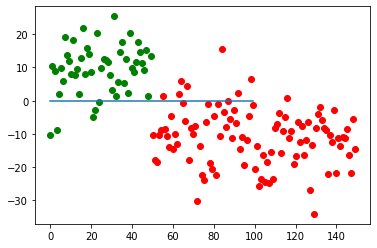

TP, TN, FP, FN for the cascade classifier:
0.9 0.92 0.08 0.1


In [ ]:
FP_test = 0.0
FN_test = 0.0
TP_test = 0.0
TN_test = 0.0

scores = []

print("Cascade:")
print(cascade)

f_cnt=1
for el in cascade:
    print(" ")

    print("// Compute " +str(f_cnt) +" feature score")
    print("vote = f_vote(greyIntegral, " +str(el.haar.type) +", w, h, scale*" +
          str(el.haar.feature.shape[1]) +", scale*" +str(el.haar.feature.shape[0]) +", scale*" +str(el.haar.start[1]) +", scale*" +str(el.haar.start[0]) +
          ", scaleTh*" +str(int(round(el.theta))) +", " +str(el.weight*el.sign) +", fovea);")
    print("cascade_score += vote;")

    f_cnt+=1

save = False

for t in range(len(testing_set)):
    strong_score = 0.0
    for w_class in cascade:
        strong_score += w_class.weight * predict(get_haar_score_fast(w_class.haar, testing_set[t], testing_integrals[t]), w_class)
    clas = np.sign(strong_score)
    scores.append(strong_score)

    if testing_labels[t] == 1 and clas == -1:
        FN_test += 1
        if save:
            plt.imshow(testing_set[t], interpolation='nearest')
            plt.savefig("FN/" +str(t) +".jpg")
    if testing_labels[t] == -1 and clas == 1:
        FP_test += 1
        if save:
            plt.imshow(testing_set[t], interpolation='nearest')
            plt.savefig("FP/" +str(t) +".jpg")
    if testing_labels[t] == 1 and clas == 1:
        TP_test += 1
        if save:
            plt.imshow(testing_set[t], interpolation='nearest')
            plt.savefig("TP/" +str(t) +".jpg")
    if testing_labels[t] == -1 and clas == -1:
        TN_test += 1
        if save:
            plt.imshow(testing_set[t], interpolation='nearest')
            plt.savefig("TN/" +str(t) +".jpg")


print(FP_test)
print(FN_test)

plt.plot(range(nrPos_test), scores[0 : nrPos_test], 'go')
plt.plot(range(nrPos_test, nrPos_test + nrNeg_test), scores[nrPos_test :], 'ro')
plt.plot(range(nrNeg_test), [0] * nrNeg_test)
plt.show()

print("TP, TN, FP, FN for the cascade classifier:")
print(TP_test/nrPos_test, TN_test/nrNeg_test, FP_test/nrNeg_test, FN_test/nrPos_test)